In [3]:
#Cargando librerías 
import importlib

import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd

import positioning_sensors as ps
importlib.reload(ps)

import network_fitness as netfit
importlib.reload(netfit)

from geneticalgorithm import geneticalgorithm as ga

from IPython.display import clear_output

import itertools as it


plt.style.use("ggplot")

In [5]:
#cargamos imagenes en luminance e importance
ilumina = 'example/inputs/qro_light_th'
niveles = 'example/inputs/prioridades'
sigma_y = 0.5
sigma_x = 0.5
sigma = [sigma_y,sigma_x]

#Loading precalculated local and directed empirical variograms

filesv = "semivariance_15_05_D.csv"
filesvmask = "semivariance_15_05_mask_D.csv"

data = pd.read_csv(filesv)
data_m = pd.read_csv(filesvmask)
variogram_set = np.array(data.iloc[:,3:])
variogram_set_m = np.array(data_m.iloc[:,3:])


#NLTI: luminance
luminance = ps.readIMG(ilumina)

#EAM: Environtmental attention map is the importance
EAM = ps.readIMG(niveles,invert=True)

nonsat,b = ps.desaturate(luminance,th=62)

variograms = variogram_set.reshape(len(variogram_set),nonsat.shape[0],nonsat.shape[1])
variograms_m = variogram_set_m.reshape(len(variogram_set),nonsat.shape[0],nonsat.shape[1])

coords = np.array(data.iloc[:,1:3])

NLTI = sp.ndimage.filters.gaussian_filter(nonsat, sigma, mode='constant')
NLTI = (NLTI>=22)*NLTI

sensitivity = ps.f5(NLTI,EAM,64)
aptitude = netfit.NetworkFitness(NLTI,EAM,sensitivity,variograms,variograms_m,coords)
aptitude.selectFitnessFunction("max")
f = aptitude.f

#Testing Objective function: all positions should produce 100%
all_coord = ps.get_coords(NLTI>0)
X_opt = all_coord.flatten()
s = 'Testing Objective Function with the {l} locations is {fitness: 3.2f}%'.format(l=len(all_coord), fitness=-f(X_opt)*100)
print(s)


 W = i*a^(p)
Selct cost functions: 
 'xor','max' or 'cover'
Testing Objective Function with the 906 locations is  100.00%


optimizing for (c,n): (160, 6)
 W = i*a^(p)
Selct cost functions: 
 'xor','max' or 'cover'
Search Space Boundaries: [[ 0 60]
 [ 0 52]
 [ 0 60]
 [ 0 52]
 [ 0 60]
 [ 0 52]
 [ 0 60]
 [ 0 52]
 [ 0 60]
 [ 0 52]
 [ 0 60]
 [ 0 52]]
 The best solution found:                                                                           
 [33. 31. 35. 15. 31. 38. 36. 25. 38. 25. 21. 14.]

 Objective function:
 -0.859874822016327


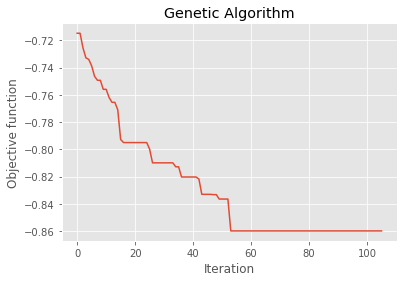

In [8]:
r2 = list([])
results = list([])


for i in it.product(np.arange(1,17,3)*10,np.arange(1,7)):
    clear_output(wait=True)
    print("optimizing for (c,n)=", i)
    c,n_sensors = i
    
    #setting the optimization function
    
    #set the sensitivity map
    sensitivity = ps.f5(NLTI,EAM,c)
    
    #set aptitude
    aptitude = netfit.NetworkFitness(NLTI,EAM,sensitivity,variograms,variograms_m,coords)
    aptitude.selectFitnessFunction("max")
    f = aptitude.f

    #variable ranges, 2 ranges per sensor position (dim*n_sensors) 
    varbound=np.array([[0,nonsat.shape[0]],[0,nonsat.shape[1]]]*n_sensors)
    print("Search over the Space Boundaries:", varbound)

    dim = len(varbound)            

    model=ga(function=f,
             dimension=dim,
             algorithm_parameters={'max_num_iteration': 2000, 'population_size': 2000, 'mutation_probability': 0.1, 'elit_ratio': 0.01, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type': 'uniform', 'max_iteration_without_improv': 50},
             variable_type='int',
             variable_boundaries=varbound)

    
    
    model.run()
    r2.append(model.output_dict["function"])
    results.append(model.output_dict["variable"])
    

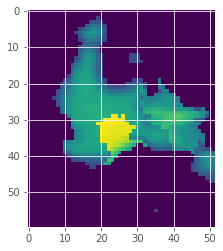

In [16]:
plt.imshow(aptitude.project(results[1])+NLTI/20)